# Differentiable Vietoris-Rips persistent homology

In this example, we essentially reproduce the toy experiment from

**Connectivity-Optimized Representation Learning via Persistent Homology**    
C. Hofer, R. Kwitt, M. Dixit and M. Niethammer    
ICML '19

## Notation

- $S$ is a mini-batch of points $x \in \mathbb{R}^2$ of size $|S|=b$
- $\dagger(S)$ is the set of death-times obtained from the VR PH of $S$
- $\eta$ is the desired lifetime value (in our case $\eta=2$)
- $\varepsilon_t, t \in \dagger(S)$ are the pairwise distance values of points in $S$

## Learning task

Given a 2D point cloud (sampled from three Gaussians), find a mapping 
$f_\theta: \mathbb{R}^2 \to \mathbb{R}^2$ (implemented via a simple MLP) such that the 
*connectivity loss* 

$$L_\eta(S) = \sum_{t \in \dagger(S)} |\eta -\epsilon_t|$$

is minimized over mini-batches of samples ($S$).


%load_ext autoreload
%autoreload 2

In [48]:
# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset, random_split

# matplotlib imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# misc
from collections import defaultdict, Counter
from itertools import combinations

# imports from chofer_torchex
from chofer_torchex.utils.data.dataset import SimpleDataset
from chofer_torchex.utils.boiler_plate import apply_model
from chofer_torchex.pershom import vr_persistence_l1

# Run everything on the GPU
device = "cuda:0"

## Toy data

First, we create a toy dataset with 2D points sampled from three Gaussians with different means and covariances. In particular, we create a class which derives from `torch.utils.data.Dataset` so we can later conveniently use PyTorch's dataloader.

In [3]:
class Toy2DData(torch.utils.data.Dataset):
    def __init__(self, n_samples_by_class):
        super().__init__()
        X = []
        Y = []        
        self.mus = [
            [4.0,4.0],
            [3.0,3.0],
            [0.0,0.5]
        ]
        self.sigmas = [
            [1.0,1.0],
            [3.0,3.0],
            [0.5,0.5]
        ]
        
        for y, (m, s) in enumerate(zip(self.mus, self.sigmas)):
            X_class = torch.randn((n_samples_by_class, 2))* torch.tensor(s) - torch.tensor(m)
            X.append(X_class)
            Y += n_samples_by_class*[0]           
        
        self.X = torch.cat(X, dim=0)
        self.Y = Y
    
    def __len__(self):
        return len(self.Y)

    def __getitem__(self, item):
        return self.X[item], self.Y[item]
    
    def __iter__(self):
        return zip(self.X, self.Y) 
        

Let's sample 1,500 points from this dataset (500 per Gaussian) and visualize the configuration in $\mathbb{R}^2$.

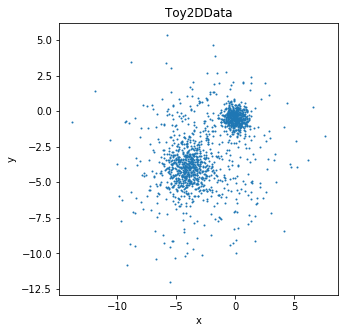

In [49]:
dataset = Toy2DData(500)

plt.figure(figsize=(5,5))
X = dataset.X.numpy()
plt.plot(X[:,0],
         X[:,1], '.',markersize=2);
plt.xlabel('x')
plt.ylabel('y')
plt.title('Toy2DData');

## Model & Optimization

We implement our mapping $f_\theta$ as a simple MLP with three linear layers, interleaved with LeakyReLU activations. For optimization we use ADAM. We run over 30 epochs with a learning rate of $0.01$ and over 20 additional epochs with a learning rate of $0.001$.

In [56]:
model = nn.Sequential(
    nn.Linear(2, 10), 
    nn.LeakyReLU(),
    nn.Linear(10, 10), 
    nn.LeakyReLU(), 
    nn.Linear(10, 2)
).to(device)


opt = torch.optim.Adam(
    model.parameters(), 
    lr=0.01)

dl = DataLoader(
    dataset, 
    batch_size=50, 
    shuffle=True, 
    drop_last=True)

# Get the transformed points at initialization
transformed_pts = [apply_model(model, dataset, device=device)[0]]

iteration_loss = []
for epoch_i in range(1, 51):
    epoch_loss = 0
    
    model.train()

    # Learning rate schedule
    if epoch_i == 20:
        for param_group in opt.param_groups:
            param_group['lr'] = 0.001
    if epoch_i == 40:
        for param_group in opt.param_groups:
            param_group['lr'] = 0.0001

    # Iterate over batches
    for x, _ in dl:        

        x = x.to(device)

        # Compute f_\theta(S)
        x_hat = model(x)

        """
        Loss computation (for \eta=2):
        
        (1) Compute VR persistent homology (0-dim)
        (2) Get lifetime values
        (3) Compute connectivity loss
        
        Note that all barcode elements are of the form (0,\varepsilon_t)!
        """
        loss = 0         
        pers = vr_persistence_l1(x_hat, 0, 0)[0][0] # VR PH computation
        pers = pers[:, 1]                           # get lifetimes
        loss = (pers - 2.0).abs().sum()             # 
    
        # Track loss over iterations and epochs
        iteration_loss.append(loss.item())
        epoch_loss += loss.item()

        # Zero-grad, backprop, update!
        opt.zero_grad()        
        loss.backward()
        opt.step()

    print('Epoch: {:2d} | Loss: {:.2f}'.format(epoch_i, epoch_loss/len(dl)), end='\r')

    x_hat, _ = apply_model(
        model, 
        dataset, 
        device=device)
    transformed_pts.append(x_hat)

Visualize the loss over all iterations ...

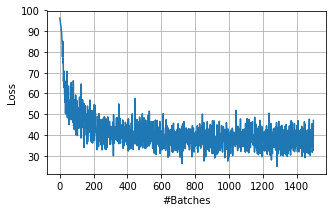

In [62]:
plt.figure(figsize=(5,3))
plt.plot(iteration_loss)
plt.xlabel('#Batches');
plt.ylabel('Loss');
plt.grid();

## Visualization

To study the effect of minimizing the connectivity loss, we freeze the model and check how the min/max/avg. lifetime changes over (1) epochs.

In [63]:
def track_persistence_info(points, batch_size, N):
    
    ds = SimpleDataset(
        torch.tensor(points), 
        [0]*len(points))
    
    dl = DataLoader(
        ds, 
        batch_size=batch_size, 
        shuffle=True, 
        drop_last=True)    
    
    stats = defaultdict(list)
    for i in range(N):
        for x,_ in dl:
    
            x =  x.to(device)
            
            pers = vr_persistence_l1(x, 0, 0)[0][0]
            pers = pers[:, 1]

            stats['alpha'].append(pers.min().item())
            stats['beta'].append(pers.max().item())
            stats['avgeps'].append(pers.mean().item())

    return stats

In [68]:
def visualize(transformed_pts, ax):
    
    pts = np.array(transformed_pts)
    x, y = pts[:,0], pts[:,1] 
    
    ax.plot(x, y, '.', **{'markersize':2, 'color':'black', 'alpha': 0.3})

    stats = track_persistence_info(
        pts, 
        50,
        10)
    
    ax.set_title(r'$\widehat{\alpha},\widehat{\varepsilon}, \widehat{\beta}$ = ' + '{:.2f}, {:.2f}, {:.2f}'.format(
                    np.mean(np.array(stats['alpha'])),
                    np.mean(np.array(stats['avgeps'])),
                    np.mean(np.array(stats['beta']))),
                  position=(0.04,0.02), 
                  fontsize=12, 
                  horizontalalignment='left',
                  bbox=dict(facecolor='white', alpha=0.7));

From left to right: Initialization (epoch 0), after 5 epochs, after 50 epochs:

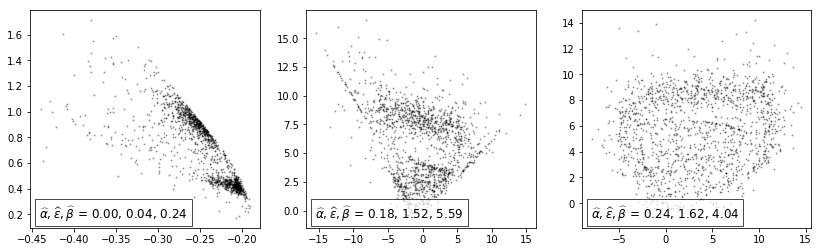

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i, epoch in enumerate([0, 5, 50]):
    ax = axes[i]
    visualize(transformed_pts[epoch], ax)

**Note**: Observe how the $[\hat{\alpha}, \hat{\beta}]$ interval gets tighter throughout the epochs and $\hat{\varepsilon}$ gets closer to $\eta=2$. However, arranging batches of size 50 in the desired manner is impossible in $\mathbb{R}^2$ which is why the actual value of $2$ is never reaches (for details see paper).